In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [3]:
df=pd.read_csv('../../Data/adult.csv')

# EDA

In [4]:
df.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

In [5]:
df.shape

(32561, 15)

Dataset has 32561 rows and 15 columns.

In [6]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

Label column has only two categories, hence it is a problem of classification. There are no constant columns nor there are any identifier column.

In [7]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

There are no null values in the dataset

In [8]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

There are 8 object type feautures rest of the features are of integer type.

In [9]:
df.skew()

age                0.558743
fnlwgt             1.446980
education.num     -0.311676
capital.gain      11.953848
capital.loss       4.594629
hours.per.week     0.227643
dtype: float64

There is skewness present in the data which needs to be removed.

In [10]:
df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

Dataset is imbalanced.

In [11]:
df.describe()

age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

All the columns are not present as they are of object type. Count of each column is 32561 showing there are no null values. Mean is very much greater than the median in capital gain and capital loss stating that there is high skewness present and data is skewed to the right side. Also there is high variance in Capital gain and Capital loss column. Min, Max, and interquartile ranges have variable difference, that means there are outliers present in the data.

### Univariate Analysis

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
df['income'].value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(x='income',data=df)
plt.ylabel('No. of People')
df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

Dataset if highly imbalanced. There is less than 25% of >50K income category while more than 75% of <=50K income.

In [13]:
#Separating categorical and continuous variables
cat=[feature for feature in df.columns if df[feature].nunique()<45]
cont=[feature for feature in df.columns if df[feature].nunique()>45]

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

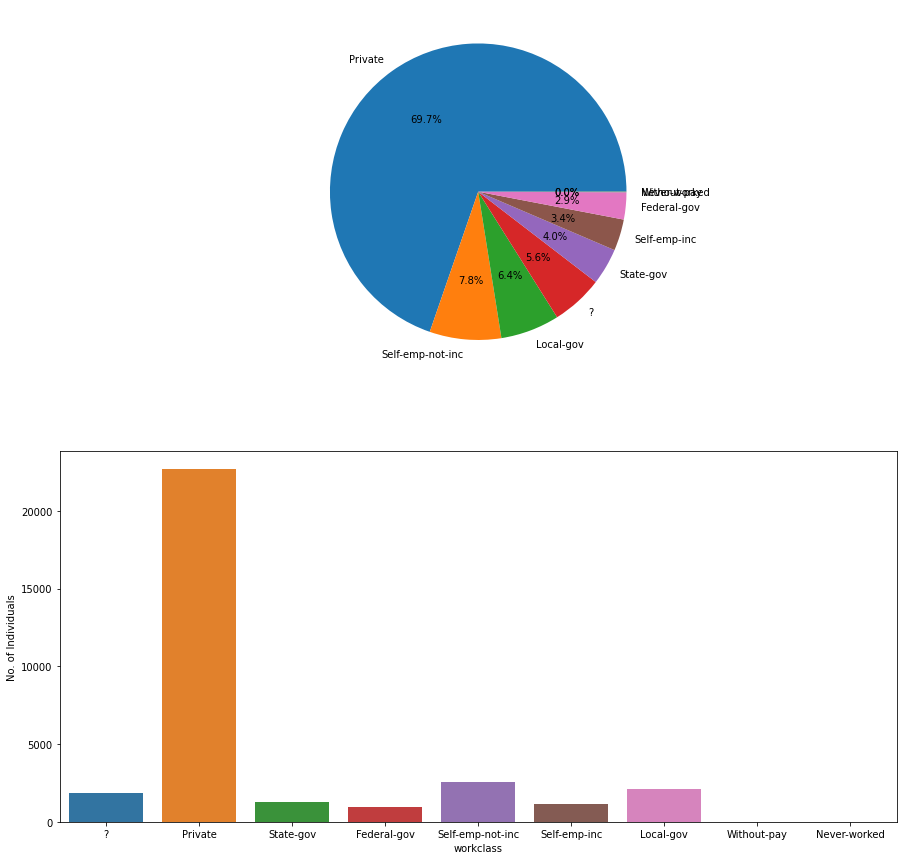

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
df['workclass'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='workclass',data=df)
plt.ylabel('No. of Individuals')
df['workclass'].value_counts()

There are 9 workclass in total including Never worked and one unknown category(?).Most individuals work in private sector and there are very few who have never worked or work without pay. There are 3 categories of govt job provided state, federal and local among which no. of people working in the local govt is highest.

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

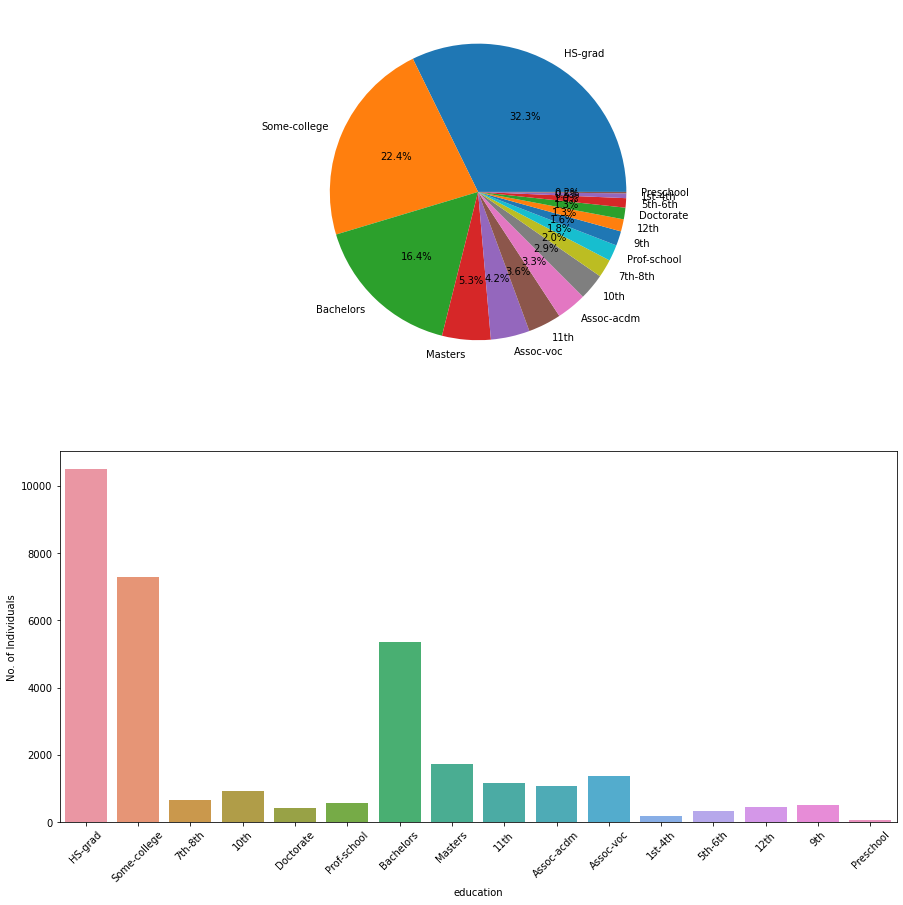

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
df['education'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='education',data=df)
plt.xticks(rotation=45)
plt.ylabel('No. of Individuals')
df['education'].value_counts()

Most of the people are high school graduate. There are few who have done masters and doctorate. The no. of people who went through just the preschool or 1st to 4th is the least.

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education.num, dtype: int64

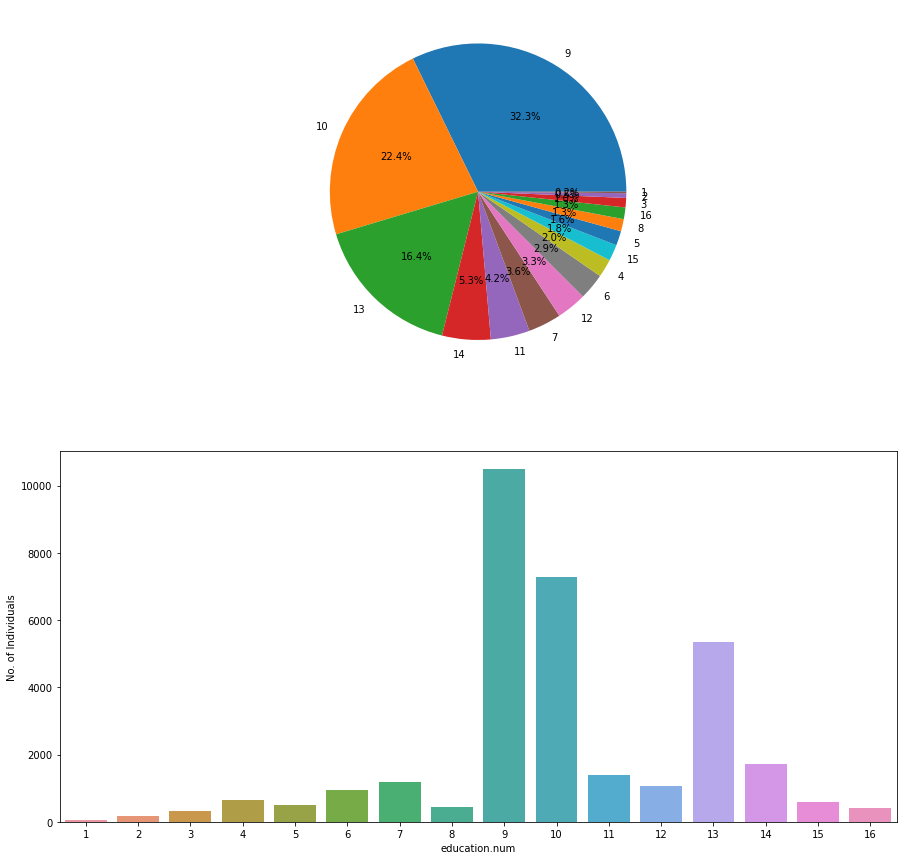

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
df['education.num'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='education.num',data=df)
plt.ylabel('No. of Individuals')
df['education.num'].value_counts()

Majority of individuals lie in the 9th 10th category of education no. which is a liitle higher than the median education number. People with least and highest educations are very few.

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

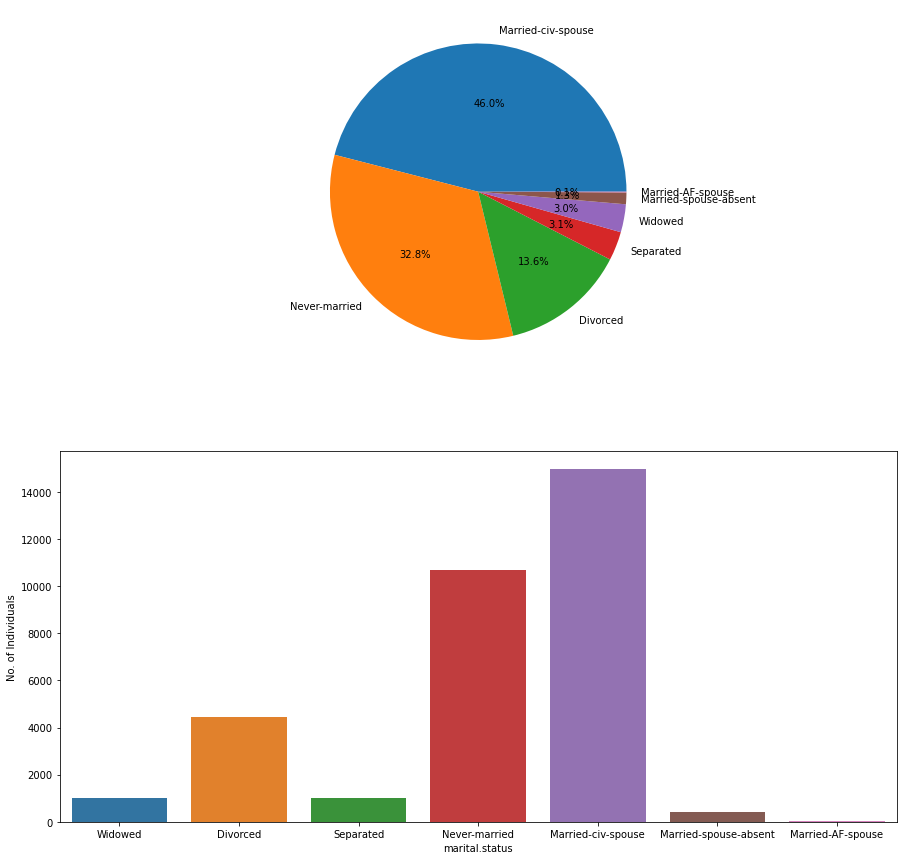

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
df['marital.status'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='marital.status',data=df)
plt.ylabel('No. of Individuals')
df['marital.status'].value_counts()

Majority of people are married to a civialian spouse or Never married. Least people are married to armed forces. From the above maritial status data we can see that there are less young people in the workforce as compared to young ones.

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

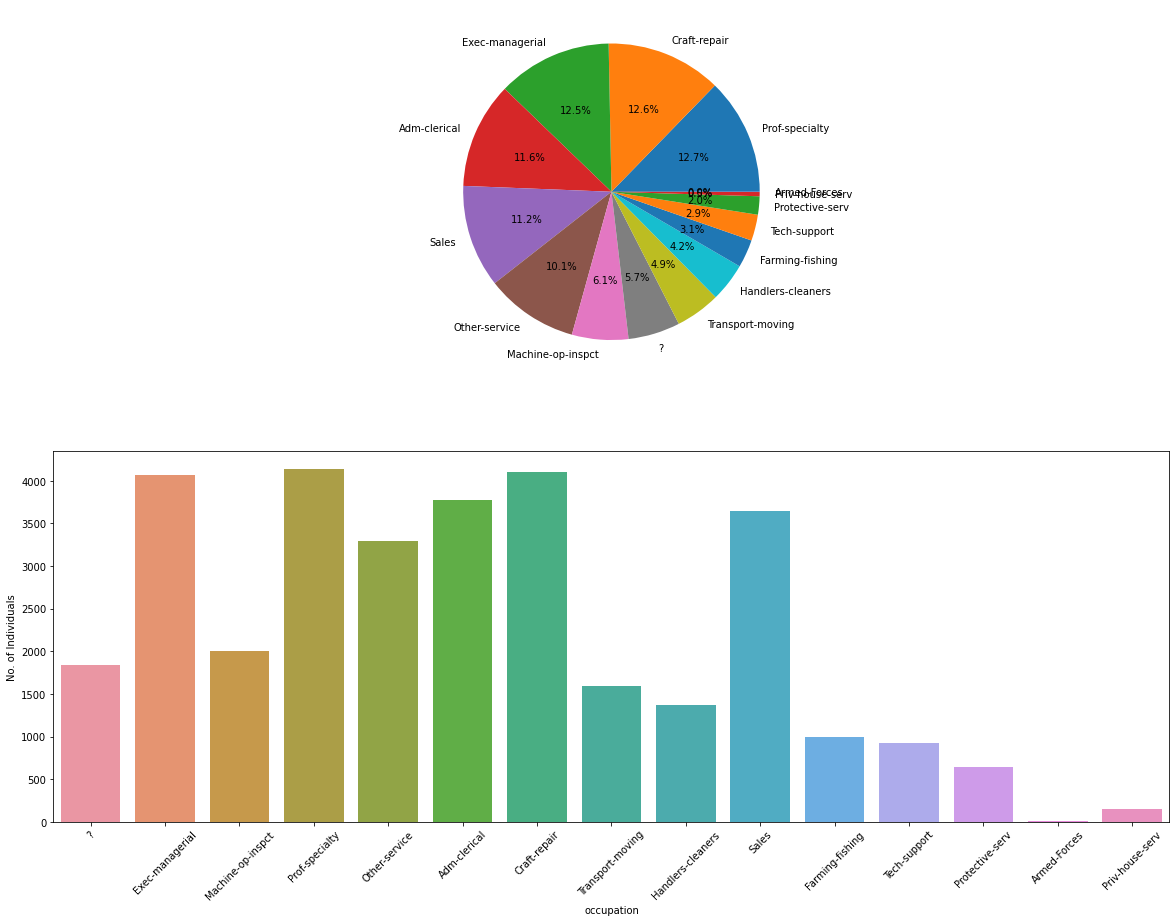

In [18]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
df['occupation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(2,1,2)
sns.countplot(x='occupation',data=df)
plt.xticks(rotation=45)
plt.ylabel('No. of Individuals')
df['occupation'].value_counts()

We can observe over here that prof-speciality has the highest number for people than any other occupation. followed by craft repair persons. Minimum occupation category is the armed forces with only 9 people in it. There is an unknown category of occupation too.

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

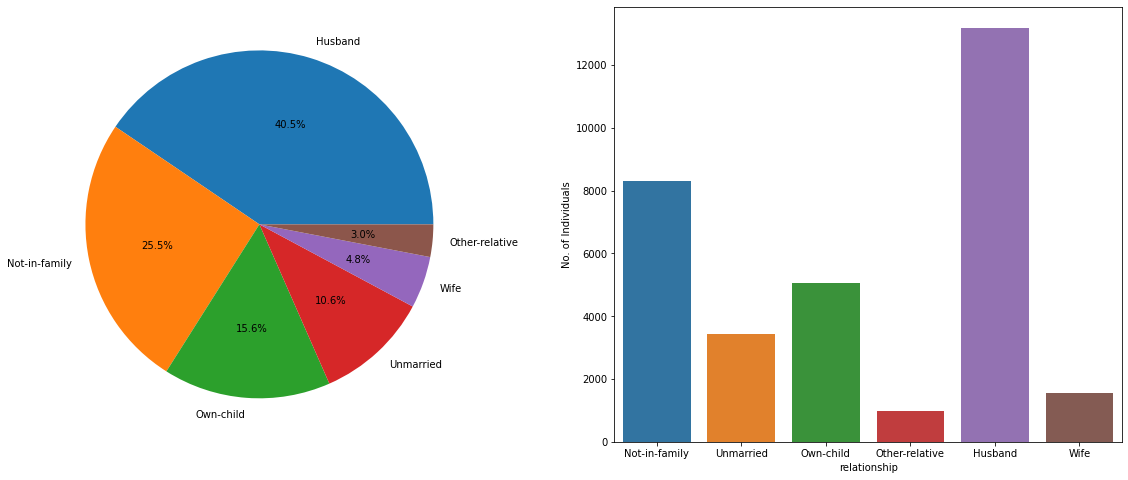

In [19]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
df['relationship'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.subplot(1,2,2)
sns.countplot(x='relationship',data=df)
plt.ylabel('No. of Individuals')
df['relationship'].value_counts()

There are much more husband working than their wives. There are 25% individuals working who fall in not in family category.

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

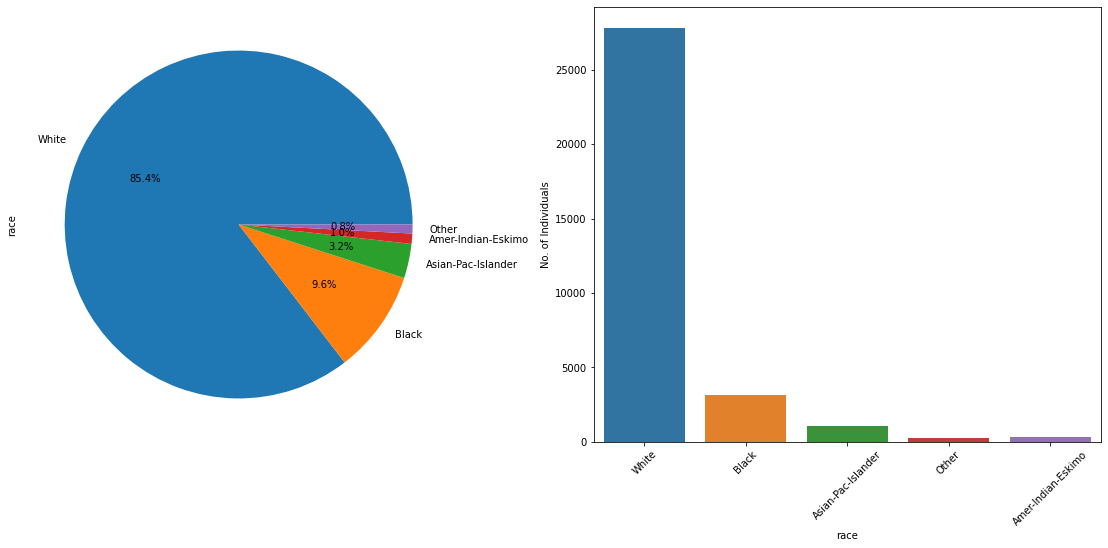

In [20]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
df['race'].value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(x='race',data=df)
plt.xticks(rotation=45)
plt.ylabel('No. of Individuals')
df['race'].value_counts()

SInce this is from european countries, most of the individuals working here are white. There is also an other category where minory races are present.

Male      21790
Female    10771
Name: sex, dtype: int64

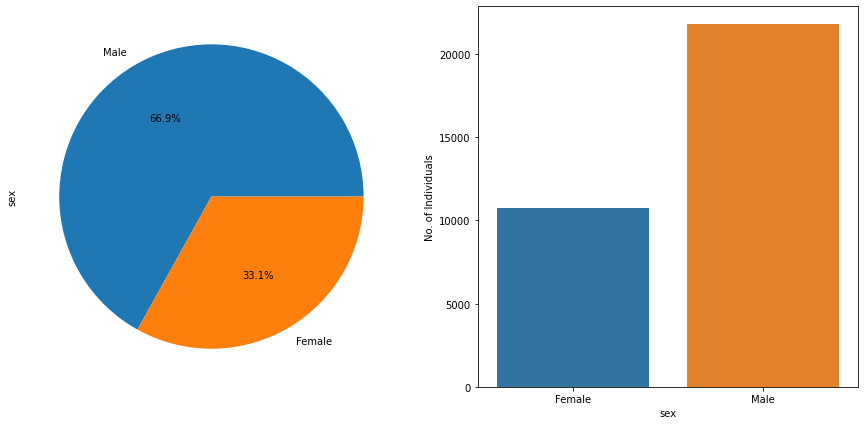

In [21]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
df['sex'].value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(x='sex',data=df)
plt.ylabel('No. of Individuals')
df['sex'].value_counts()

There is more than double the number of men working than the no. of women.

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

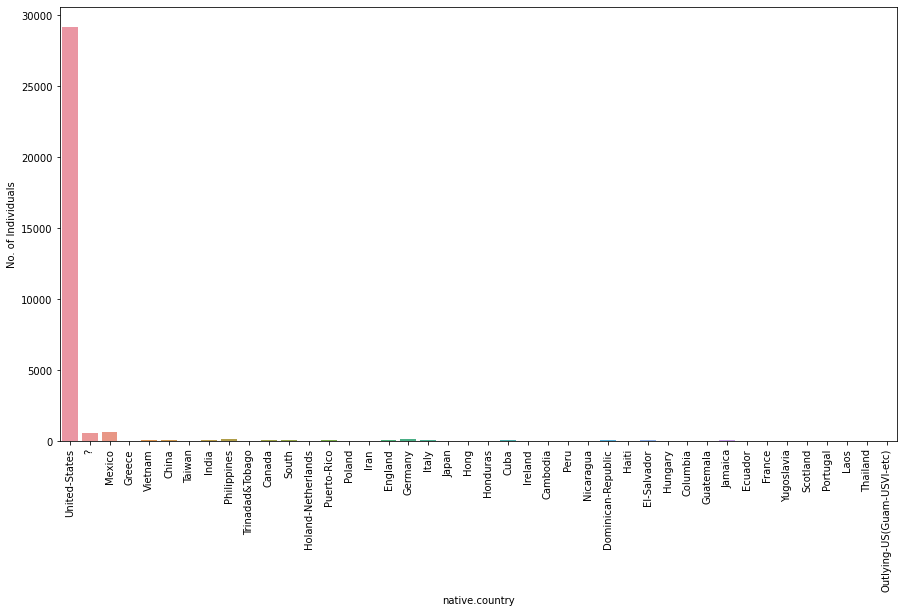

In [22]:
plt.figure(figsize=(15,8))
sns.countplot(x='native.country',data=df)
plt.xticks(rotation=90)
plt.ylabel('No. of Individuals')
df['native.country'].value_counts()

Majority of the people working belong from U.S. whereas there are people who come to U.S. from their own countries but there no. is very low. Second highest no. of people belong from Mexico as it is a neighboring country.

Minimum 17
Maximum 90


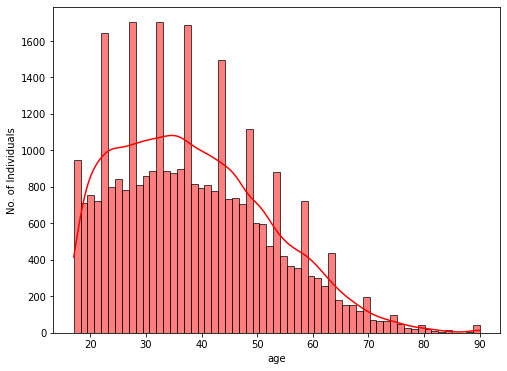

In [23]:
plt.figure(figsize=(8,6))
sns.histplot(df['age'],kde=True,color='r')
plt.ylabel('No. of Individuals')
print('Minimum',df['age'].min())
print('Maximum',df['age'].max())

Minimum age of a working individual is 17 and highest is 90 which is way far retirement, but majority of the people working are in the age 25 to 45. Data is skewed to the right side.

Minimum 12285
Maximum 1484705


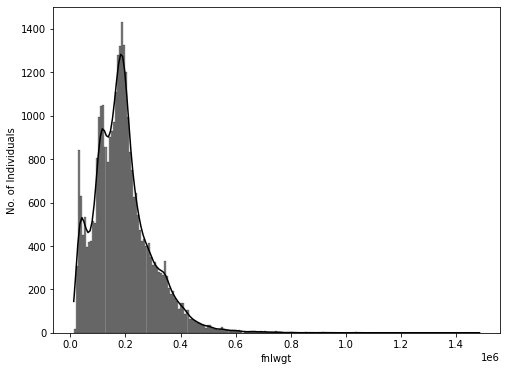

In [24]:
plt.figure(figsize=(8,6))
sns.histplot(df['fnlwgt'],kde=True,color='k')
plt.ylabel('No. of Individuals')
print('Minimum',df['fnlwgt'].min())
print('Maximum',df['fnlwgt'].max())

It is assigned by combination of features and has the peak wt as 0.2*1e6. Data does not follow normal distribution and data is rigt skewed.

Minimum 0
Maximum 99999


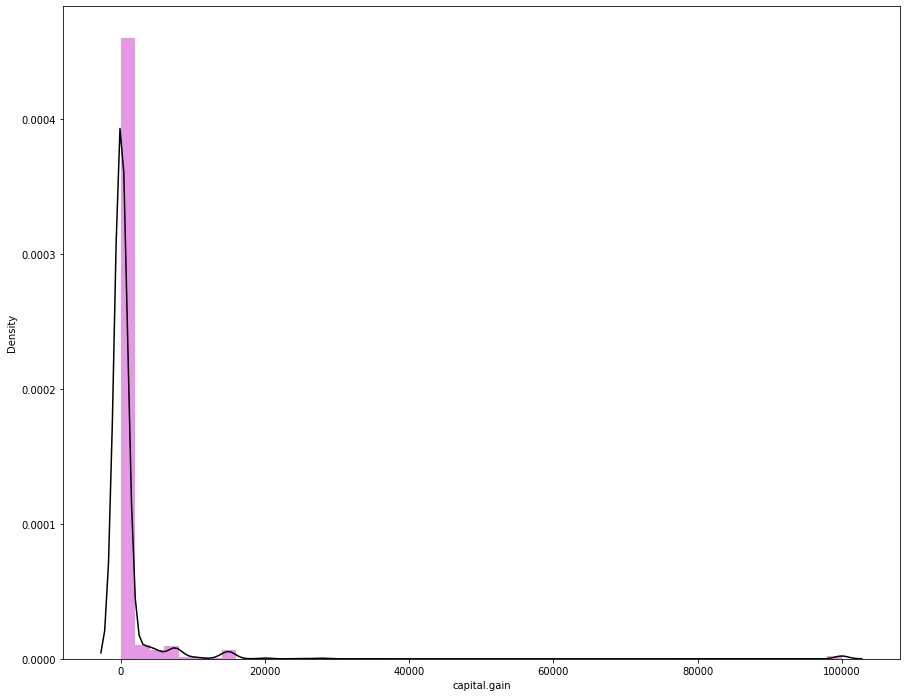

In [25]:
plt.figure(figsize=(15,12))
sns.distplot(df['capital.gain'],color='m', kde_kws={"color": "k"})
print('Minimum',df['capital.gain'].min())
print('Maximum',df['capital.gain'].max())

Minimum capital gain is 0 while the range goes on to 99999 but most of the people are with the gain of 1000. Data is highly skewed with a very long tail due to presence of large outliers. Outliers here are very few people belonging to elite class who have very large capital gains.

Minimum 0
Maximum 4356


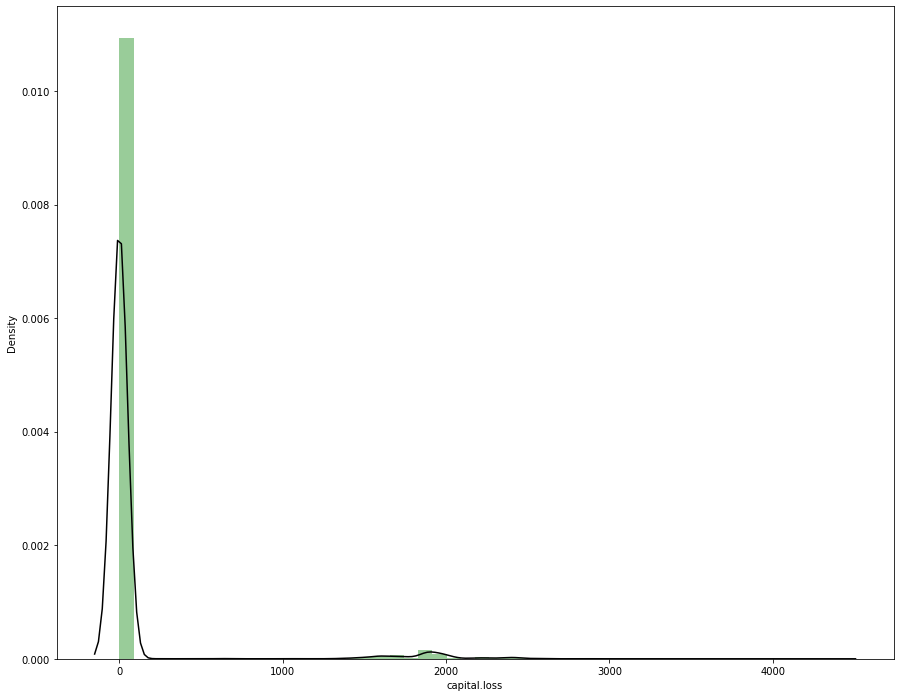

In [26]:
plt.figure(figsize=(15,12))
sns.distplot(df['capital.loss'],color='g', kde_kws={"color": "k"})
print('Minimum',df['capital.loss'].min())
print('Maximum',df['capital.loss'].max())

Minimum capital loss is 0 while the range goes on above 4000 but most of the people are with the loss of 1000. There is also a slight peak seen near 2000. Data is highly skewed with a long tail to the right side.

Minimum 1
Maximum 99


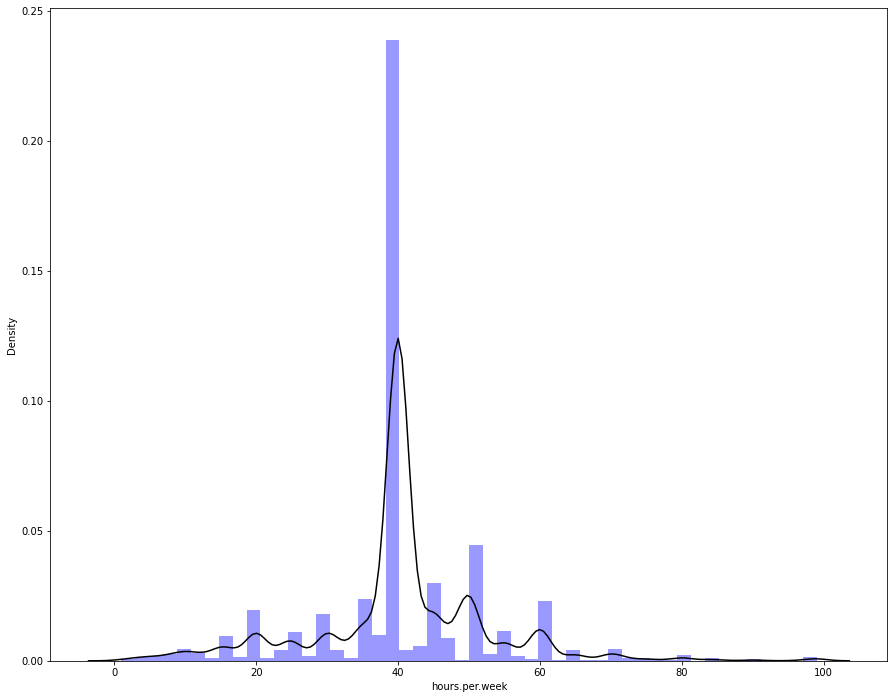

In [27]:
plt.figure(figsize=(15,12))
sns.distplot(df['hours.per.week'],color='b', kde_kws={"color": "k"})
print('Minimum',df['hours.per.week'].min())
print('Maximum',df['hours.per.week'].max())

Most of the people work 40 hours a day where there is a high chance that they belong to private sector. There are people working as low ass 1 hour a week and as high as 99 hours a week which undoubtfully might belong from the armed forces. Data shows less skewness compared to the other features in the dataframe.

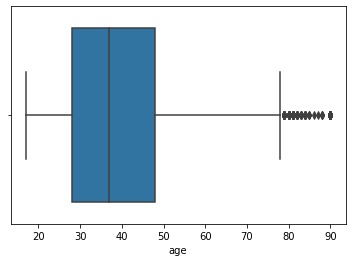

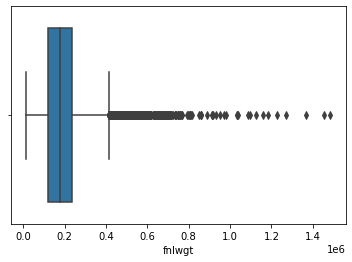

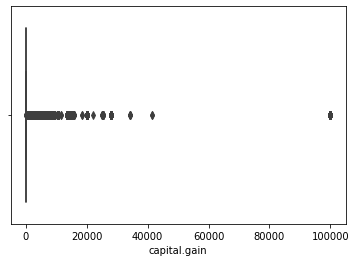

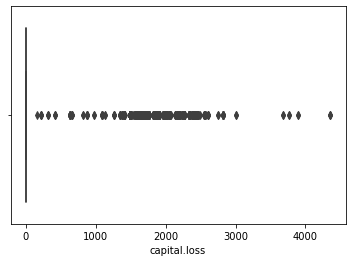

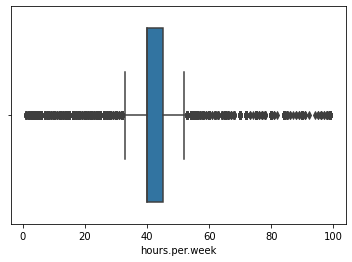

<Figure size 432x288 with 0 Axes>

In [28]:
for i in cont:
    sns.boxplot(df[i])
    plt.figure()

There are outliers in all the features, while capital gain and capital loss have very vast no. of outliers.

### Bivariate Analysis

<AxesSubplot:xlabel='income', ylabel='workclass'>

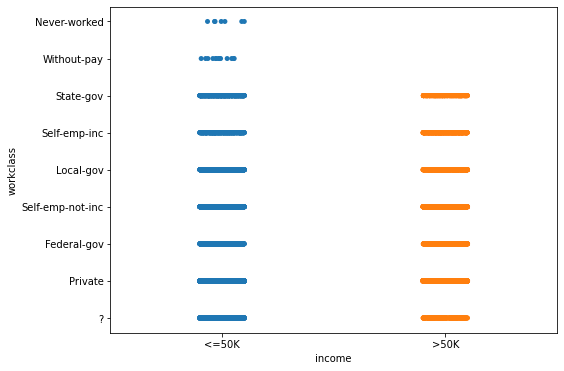

In [29]:
plt.figure(figsize=(8,6))
sns.stripplot(x='income',y='workclass',data=df)

There are individuals belonging from every workclass who earn >50k except for never worked and without pay, and even there no. is low in the <=50k category.

<AxesSubplot:xlabel='income', ylabel='education'>

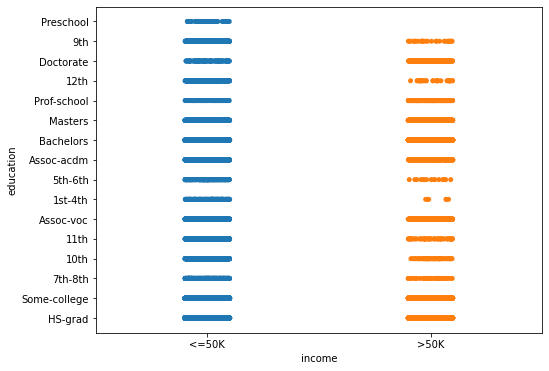

In [30]:
plt.figure(figsize=(8,6))
sns.stripplot(x='income',y='education',data=df)

There is no individual who has done preschool and earns >50k salary while there are few who earn 50k even after going through 1st-4th and 5th-6th in the education criteria. It is also to be noticed that there are doctorates and prof who earn <=50k even with such high education. 

<AxesSubplot:xlabel='income', ylabel='education.num'>

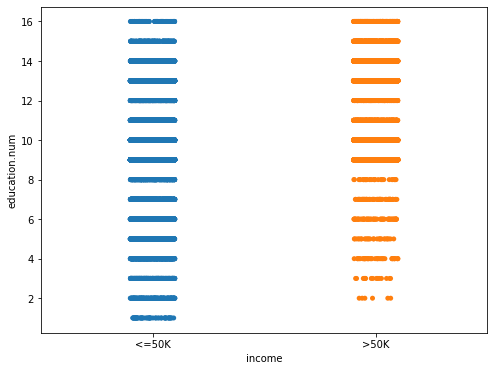

In [31]:
plt.figure(figsize=(8,6))
sns.stripplot(x='income',y='education.num',data=df)

It is clearly seen that as the education no. increases chances of earning >50K salary also increases

<AxesSubplot:xlabel='income', ylabel='marital.status'>

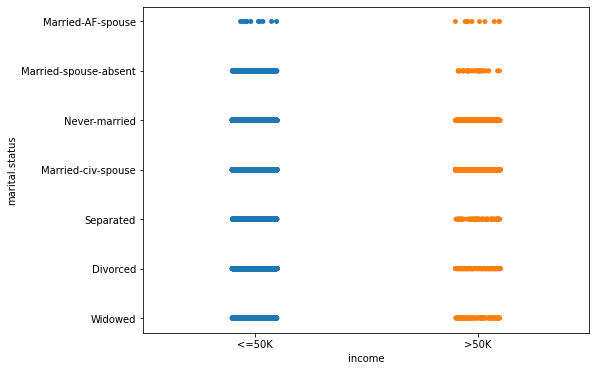

In [32]:
plt.figure(figsize=(8,6))
sns.stripplot(x='income',y='marital.status',data=df)

There are less no. of individual who are married armed forces spouse, thats why the no. is less in both the categories while people with married spouse absent are less in >50k category income comparatively.

<AxesSubplot:xlabel='income', ylabel='occupation'>

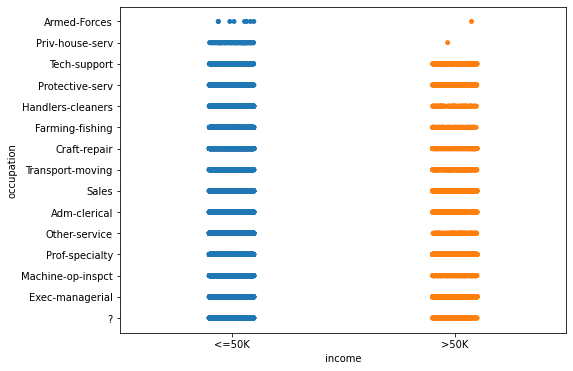

In [33]:
plt.figure(figsize=(8,6))
sns.stripplot(x='income',y='occupation',data=df)

There are very few people with income greater than armed forces and private house service while all the other categories of people are distributed evenly in both the income categories.

<AxesSubplot:xlabel='income', ylabel='native.country'>

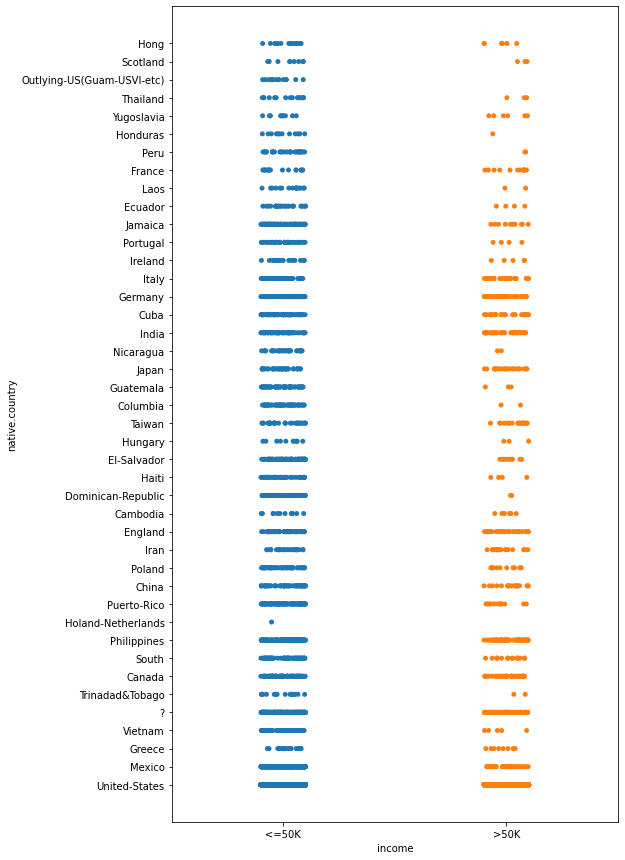

In [34]:
plt.figure(figsize=(8,15))
sns.stripplot(x='income',y='native.country',data=df)

The grapghs shows people belonging to diff countries have less chances of earning >50k which is wrong, this is because no. of individuals belonging from other countries other than U.S are very low nut it is to be noticed that there are more people in the category <=50k than >50k.

<AxesSubplot:xlabel='income', ylabel='age'>

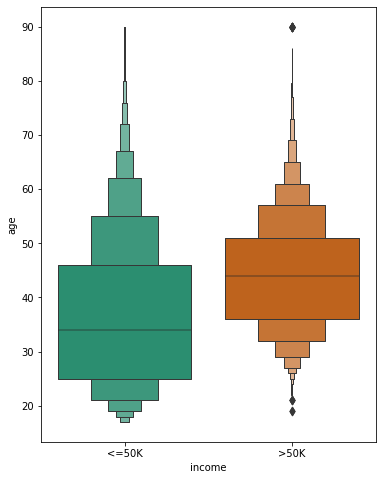

In [35]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='income',y='age',data=df,palette="Dark2")

People with higher mean age earn >50k while there are individuals earning <=50k even wat very high age.

<AxesSubplot:xlabel='income', ylabel='fnlwgt'>

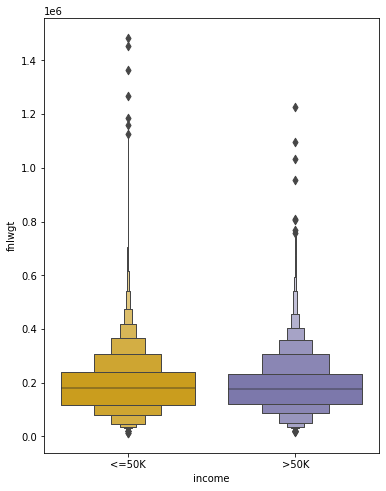

In [36]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='income',y='fnlwgt',data=df,palette="Dark2_r")

People are equally divided with respect to fnlwgt in the income category while it is seen that as the fnlwt is high indiduals fall into <=50k income category.

<AxesSubplot:xlabel='income', ylabel='capital.gain'>

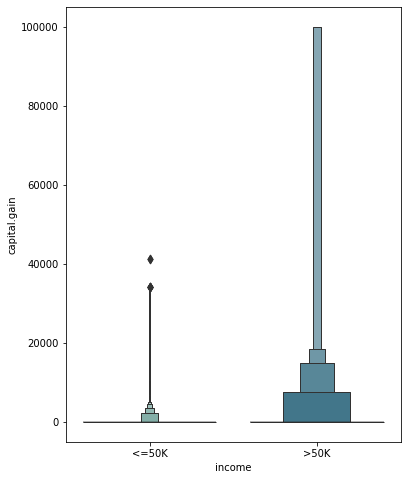

In [37]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='income',y='capital.gain',data=df,palette="crest")

As the capital gain increases more people fall into >50k salary while mean of both categories remain cloase to zero capital.gain

<AxesSubplot:xlabel='income', ylabel='capital.loss'>

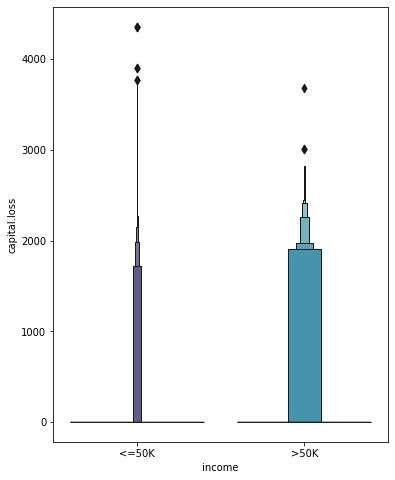

In [38]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='income',y='capital.loss',data=df,palette="ocean")

There is more density in the >50k income category with increase in capital loss while mean of both categories remain cloase to zero capital.gain

<AxesSubplot:xlabel='income', ylabel='hours.per.week'>

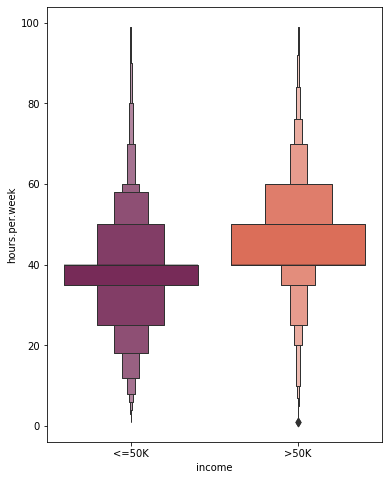

In [39]:
plt.figure(figsize=(6,8))
sns.boxenplot(x='income',y='hours.per.week',data=df,palette="rocket")

People earning >50K income work mean hours per week greater than tose earning <50K while people from both the categories work from min to max hours per week.

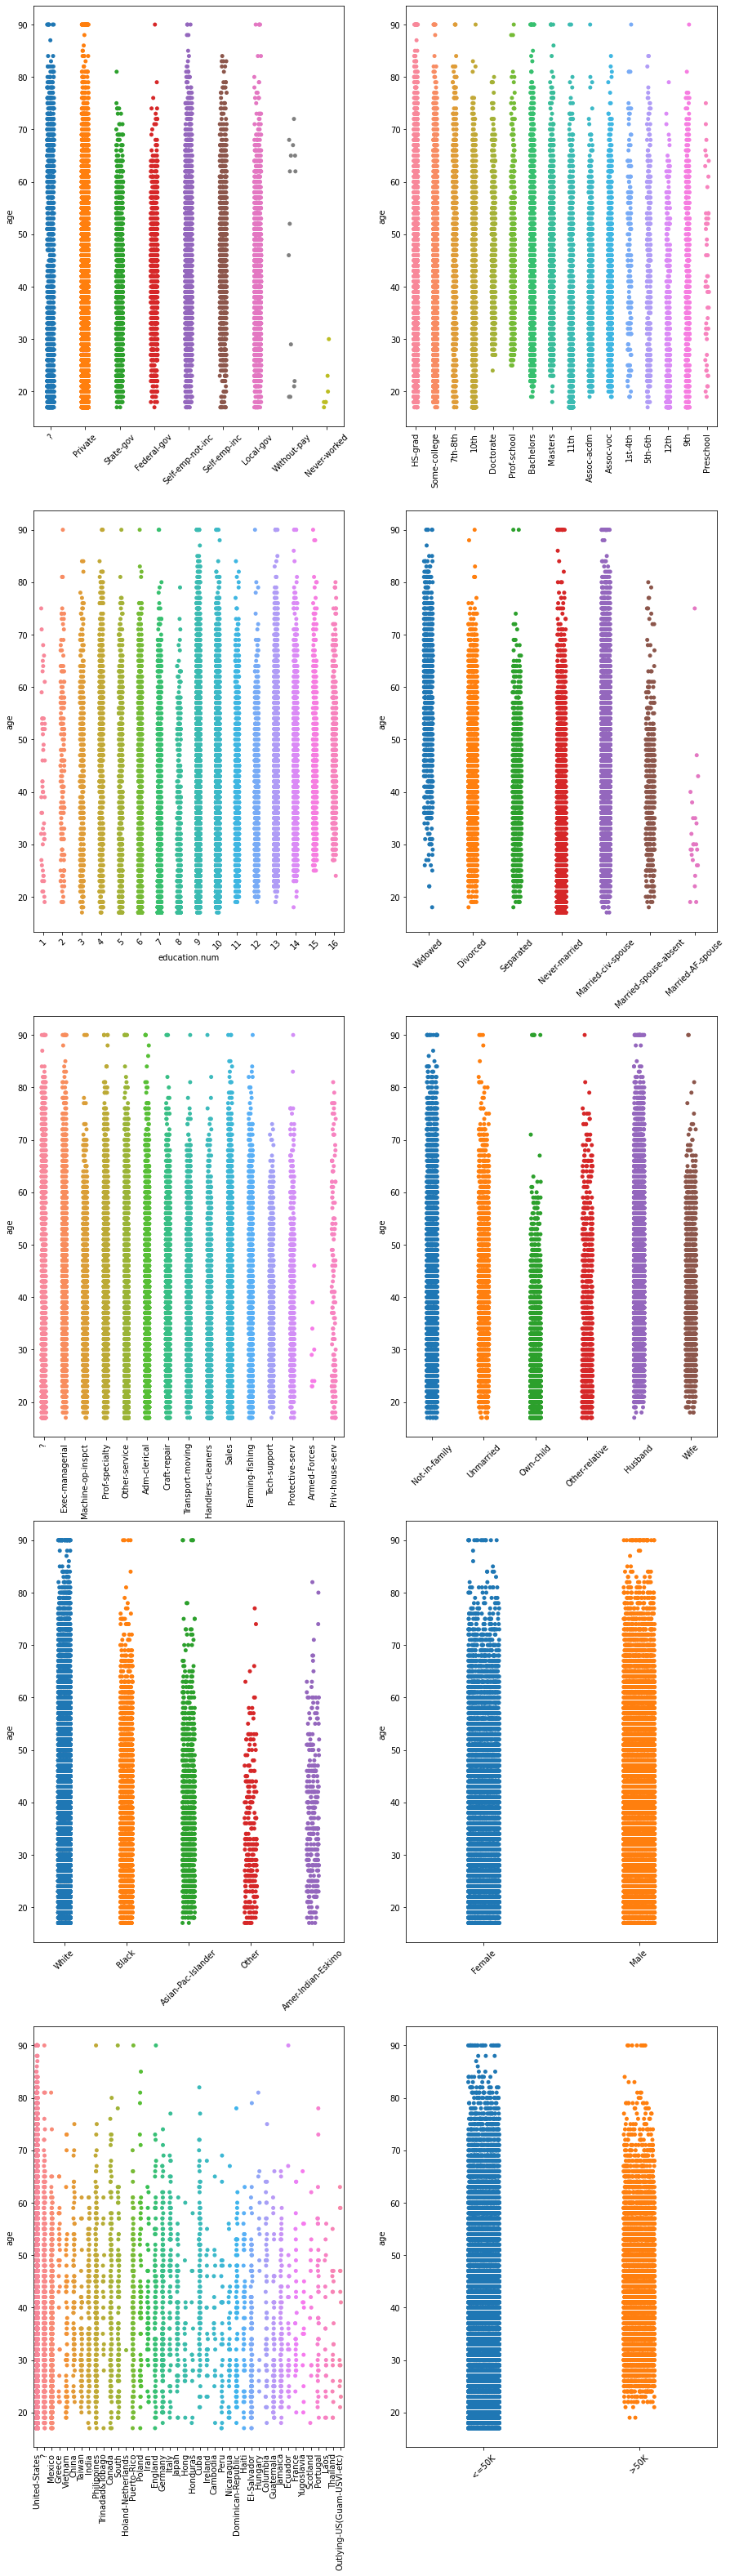

In [40]:
#age vs Categorical features
fig,ax=plt.subplots(5,2,figsize=(15,55))
r=0
c=0
for i,n in enumerate(cat):
    if i%2==0 and i>0:
        r+=1
        c=0
    graph=sns.stripplot(x=n,y='age',data=df,ax=ax[r,c])
    if n=='native.country' or n=='occupation' or n=='education':
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 90)
    else:
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 45)
    if n!='education.num':
        graph.set(xlabel=None)
    c+=1

Individuals working in the government secctor have atmost age 70 to 80 with few outliers which must be the retirement age for them. There are no individuals who do not work after age of 30. There are no individuals of age >70 belonging to the pre school education category while Doctorates and proffessors appear from late 20's as they have to study for more years to get to that level of education. Same is the case with education num, as the education number increases age also is increased. There are no people after the age of 50 in the married to armed forces category with just a few outliers. Widowed category has seen increase as the age age seem to increase, there are very few widows at an early age. There are less people with high age from other races than the white race. There are more no. of working men at higher age than women. There are very few people belonging from other countries with high age.

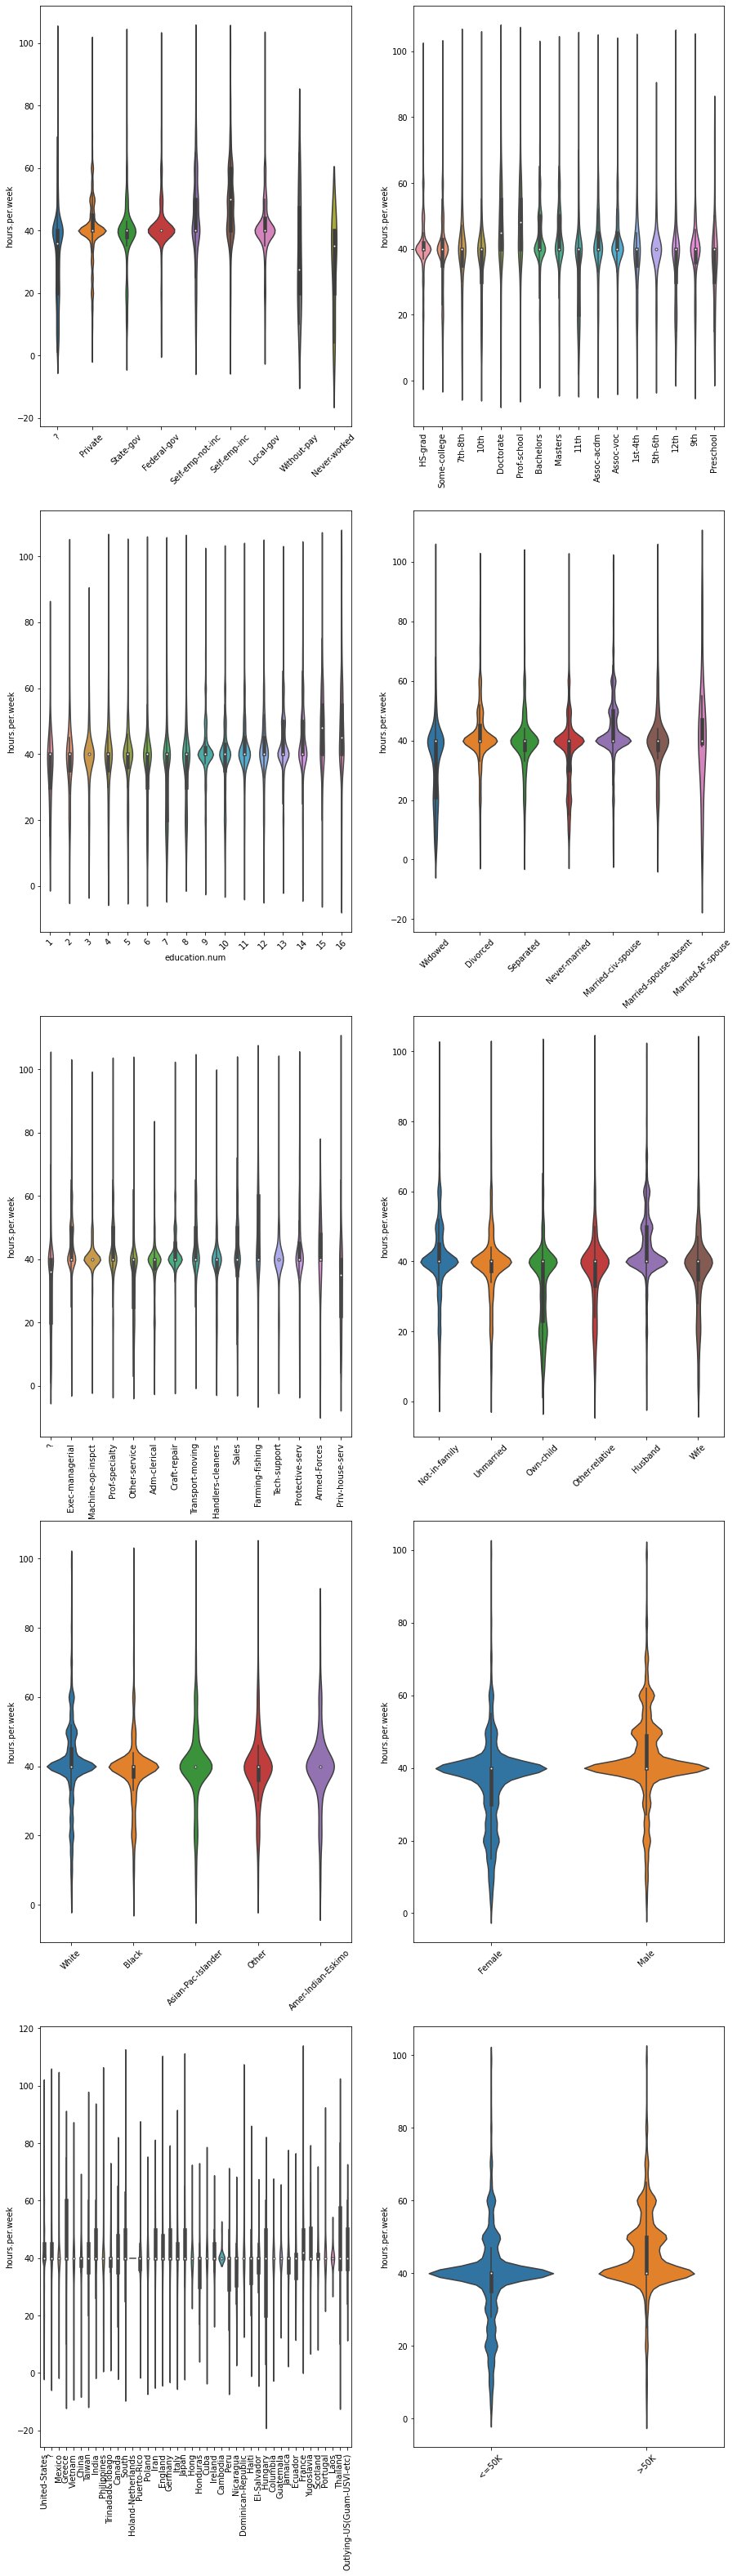

In [41]:
#Hours per week vs categorical Feature
fig,ax=plt.subplots(5,2,figsize=(15,55))
r=0
c=0
for i,n in enumerate(cat):
    if i%2==0 and i>0:
        r+=1
        c=0
    graph=sns.violinplot(x=n,y='hours.per.week',data=df,ax=ax[r,c])
    if n=='native.country' or n=='occupation' or n=='education':
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 90)
    else:
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 45)
    if n!='education.num':
        graph.set(xlabel=None)
    c+=1

Govt employees do not work more than 80 hours a week that also with rare cases. It is seen that people with less education worl more no. hours of the week which is quite logical. No armed force person works more than 60 hours a week while farmers and transport movers has working hours mean higher than other occupation. More no, of individuals who have relationship as own child have high density for working only 20 hous a week. Female works for less no. of hours as compared to men.

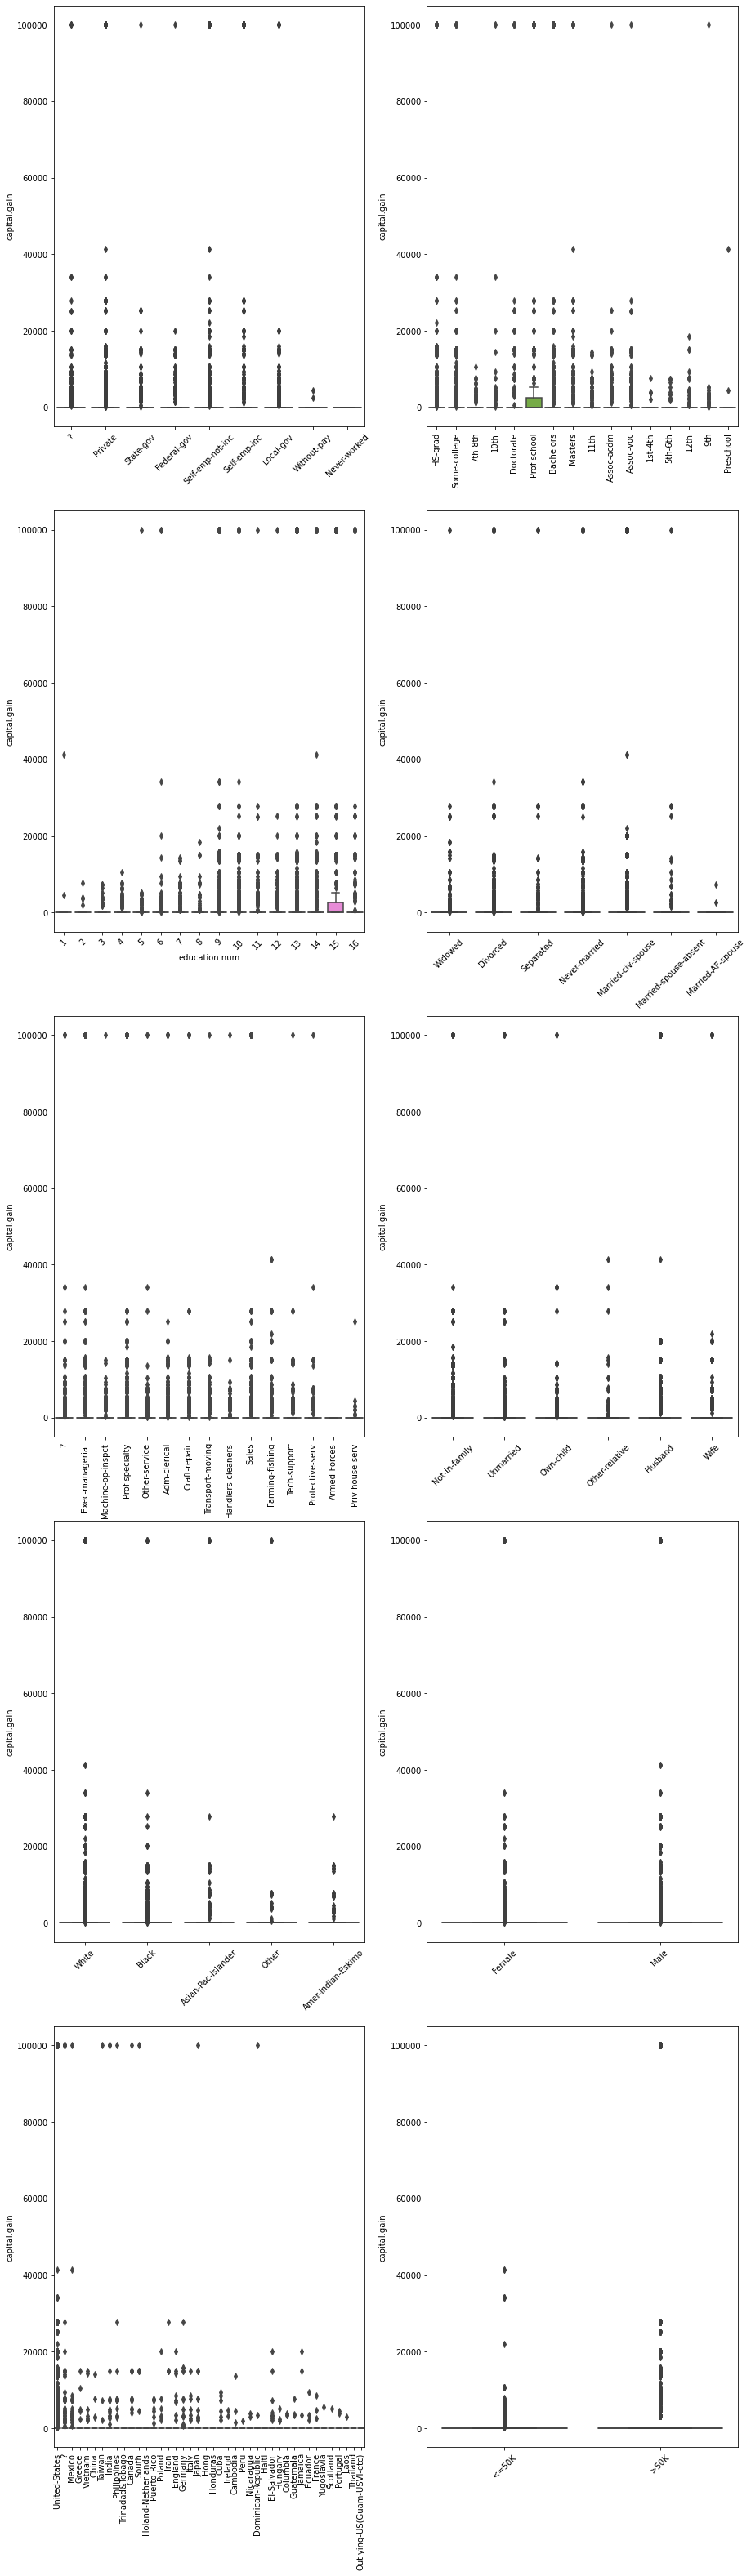

In [42]:
#Capital gain vs categorical Feature
fig,ax=plt.subplots(5,2,figsize=(15,55))
r=0
c=0
for i,n in enumerate(cat):
    if i%2==0 and i>0:
        r+=1
        c=0
    graph=sns.boxplot(x=n,y='capital.gain',data=df,ax=ax[r,c])
    if n=='native.country' or n=='occupation' or n=='education':
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 90)
    else:
        graph.set_xticklabels(graph.get_xticklabels(),rotation = 45)
    if n!='education.num':
        graph.set(xlabel=None)
    c+=1

Highest capital gains are seen in individuals belonging to private or self employed workclass. There are more no. of prof-school  than any other education category with highest capital gains. There are individuals even with preschool knowledge have capital gain more than 40000. As the education level increases capital gain also increases. People from the armed forces have the least capital gain while most prominent capitals gains are found in people who are in the sales occupation. Whites have more capital gains than any other race. Men also seem to have high capital gains as compared to females. There are many people from <=50k income category who have captital gains more than 10000.

### Multivariate Analysis

In [43]:
data=df.groupby(['age','income']).apply(lambda x:x['hours.per.week'].count()).reset_index(name='Hours')
px.line(data,x='age',y='Hours',color='income',title='age of individuals by Hours of work in the income category  ')

People earning <=50k tend to work for high no. of hours at a young age and the no. of hours decreases as the age increases but still they work for more no. of hours even at a later age as compared to people earning >50K

Text(0, 0.5, 'Average age')

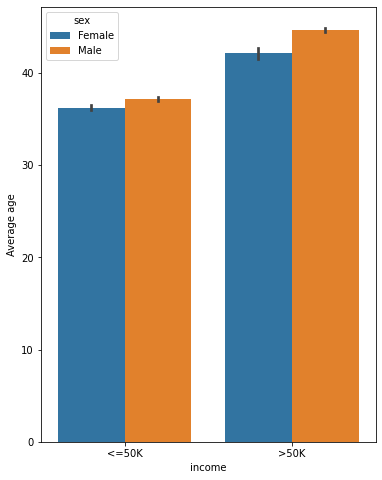

In [44]:
plt.figure(figsize=(6,8))
sns.barplot(x='income',y='age',hue='sex',data=df)
plt.ylabel('Average age')

As the age increases  people are paid more but males are paid more than females.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '?'),
  Text(1, 0, 'Private'),
  Text(2, 0, 'State-gov'),
  Text(3, 0, 'Federal-gov'),
  Text(4, 0, 'Self-emp-not-inc'),
  Text(5, 0, 'Self-emp-inc'),
  Text(6, 0, 'Local-gov'),
  Text(7, 0, 'Without-pay'),
  Text(8, 0, 'Never-worked')])

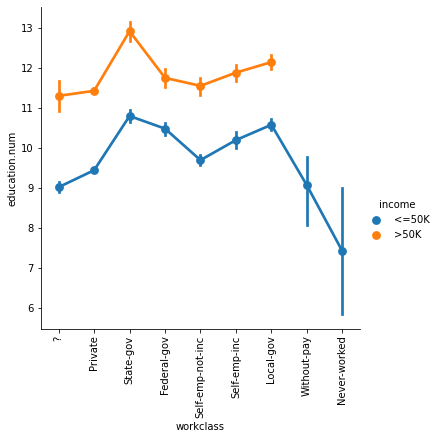

In [45]:
sns.factorplot(x='workclass',y='education.num',hue='income',data=df)
plt.xticks(rotation=90)

Some people belonging to a particular workclass might have less education and some workclass might require more education level, but no matter whatever workclass, people in the same workclass, if they have higher education level they earn more. It is also to be noticed that there is no person from without pay and never worked workclass category who earn more than 50k which is logical.

(array([0, 1]), [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

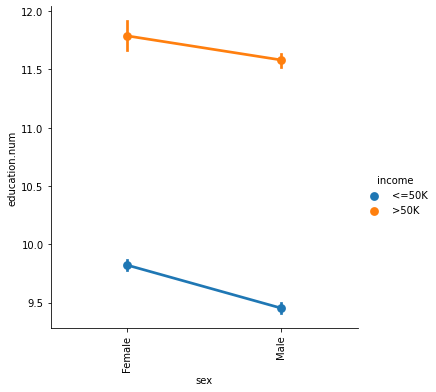

In [46]:
sns.factorplot(x='sex',y='education.num',hue='income',data=df)
plt.xticks(rotation=90)

Females with higher education level earn equal to men having less education level than them irrespective of any income category they fall.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'White'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Asian-Pac-Islander'),
  Text(3, 0, 'Other'),
  Text(4, 0, 'Amer-Indian-Eskimo')])

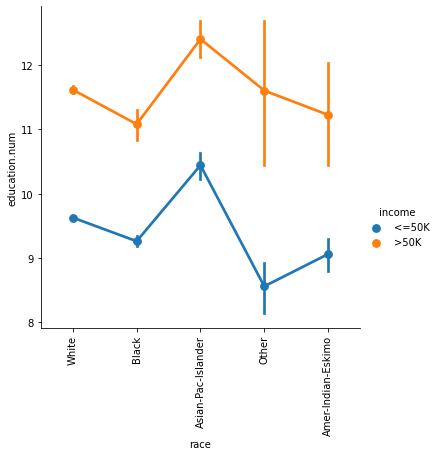

In [47]:
sns.factorplot(x='race',y='education.num',hue='income',data=df)
plt.xticks(rotation=90)

Asian pacific race have comparatively more education than the fellows who earn same as much as they do, belonging to other races. Indians and some other races earn >50k with lowest education level.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '?'),
  Text(1, 0, 'Exec-managerial'),
  Text(2, 0, 'Machine-op-inspct'),
  Text(3, 0, 'Prof-specialty'),
  Text(4, 0, 'Other-service'),
  Text(5, 0, 'Adm-clerical'),
  Text(6, 0, 'Craft-repair'),
  Text(7, 0, 'Transport-moving'),
  Text(8, 0, 'Handlers-cleaners'),
  Text(9, 0, 'Sales'),
  Text(10, 0, 'Farming-fishing'),
  Text(11, 0, 'Tech-support'),
  Text(12, 0, 'Protective-serv'),
  Text(13, 0, 'Armed-Forces'),
  Text(14, 0, 'Priv-house-serv')])

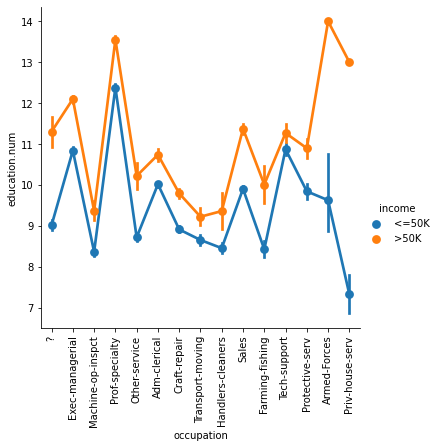

In [48]:
sns.factorplot(x='occupation',y='education.num',hue='income',data=df)
plt.xticks(rotation=90)

People with highest education level belong to armed forces, but people with even education level quite low, who belong to handlers cleaners, transport moving  occupation earn as much as they do. Same is the case with prof speciality. occupation of private house service who earn >50k and <50k have the highest education level difference while prof speciality have the minimum difference.

<AxesSubplot:xlabel='age', ylabel='hours.per.week'>

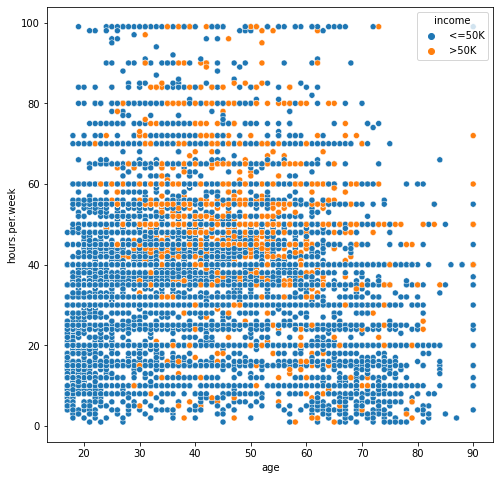

In [49]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='age',y='hours.per.week',hue='income',data=df)

From the scatterplot between age, hours.per.week and income, we observe that a person needs to be >30 to be earning more than 50K, else needs to work at least 60 hours.per.week to earn >50K.

<AxesSubplot:>

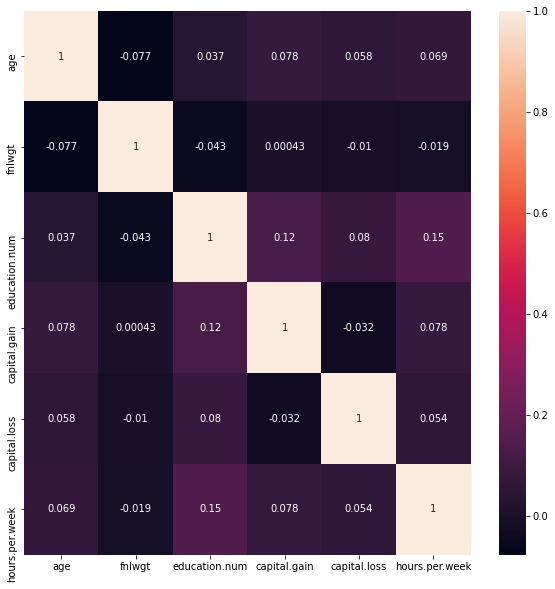

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

There are only few features in the above heat map as most of them are of object type. From here we can see that the independent features don not have much correlation with each other i.e. no multicollinearity.

# Feature Engineering

###### Encoding

In [51]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
l=LabelEncoder()
o=OrdinalEncoder()

In [52]:
#We use ordinal encoder to Encode Independent features
for i in df.columns:
    if df[i].dtypes=='O' and i!='income':
        df[i]=o.fit_transform(df[i].values.reshape(-1,1))

In [53]:
#We use label encoder to encode label 
df['income']=l.fit_transform(df['income'])

##### Removing Outliers

In [54]:
from scipy.stats import zscore

In [55]:
#Method to find optimum threshold
def threshold():
    for i in np.arange(3,5,0.2):
        data=df.copy()
        data=data[(z<i).all(axis=1)]
        loss=(df.shape[0]-data.shape[0])/df.shape[0]*100
        print('With threshold {} data loss is {}%'.format(np.round(i,1),np.round(loss,2))) 

In [56]:
z=np.abs(zscore(df))
threshold()

With threshold 3.0 data loss is 15.79%
With threshold 3.2 data loss is 12.17%
With threshold 3.4 data loss is 11.1%
With threshold 3.6 data loss is 10.2%
With threshold 3.8 data loss is 9.0%
With threshold 4.0 data loss is 8.44%
With threshold 4.2 data loss is 7.46%
With threshold 4.4 data loss is 6.08%
With threshold 4.6 data loss is 4.37%
With threshold 4.8 data loss is 1.55%


From above we choose threhold as 4.2 as data is precious and we cannot afford to lose more than 8% of data.

In [57]:
df=df[(z<4.2).all(axis=1)]

###### Removing Skewness

In [58]:
#using Power transformer to remove skewness
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer()

In [59]:
for i in cont:
    if np.abs(df[i].skew())>0.5:
        df[i]=pt.fit_transform(df[i].values.reshape(-1,1))

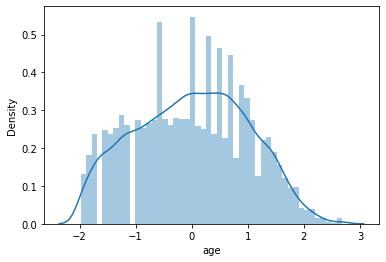

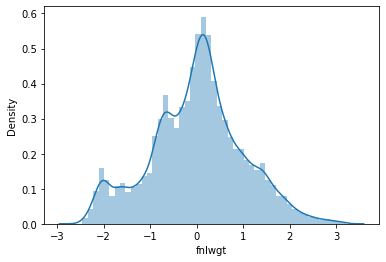

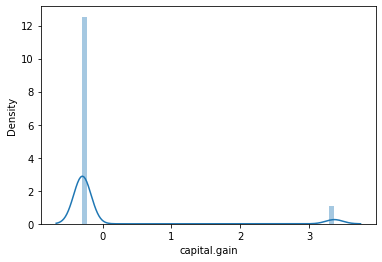

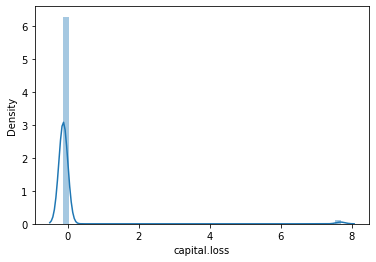

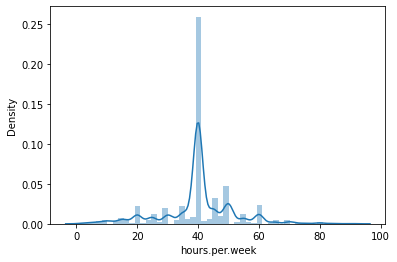

<Figure size 432x288 with 0 Axes>

In [60]:
for i in cont:
    sns.distplot(df[i])
    plt.figure()

A lot of skewness has been resuced but we cannot remove skewness more than this.

In [61]:
#Separating dependent and independent features.
x=df.copy()
x.drop('income',axis=1,inplace=True)
y=df['income']

In [62]:
x

age  workclass    fnlwgt  education  education.num  \
993   -1.111495        4.0 -1.814520       11.0              9   
994   -1.576984        0.0 -0.680310        1.0              7   
995   -0.706882        6.0  0.424877       15.0             10   
996    1.391427        4.0  0.500601       11.0              9   
997   -1.111495        4.0 -1.087030       11.0              9   
...         ...        ...       ...        ...            ...   
32556 -1.335418        4.0  1.186849       15.0             10   
32557 -0.803248        4.0  0.764117        7.0             12   
32558  0.267891        4.0 -0.214107       11.0              9   
32559  1.340658        4.0 -0.241150       11.0              9   
32560 -1.335418        4.0  0.265661       11.0              9   

       marital.status  occupation  relationship  race  sex  capital.gain  \
993               4.0         8.0           1.0   4.0  0.0     -0.296771   
994               3.0         0.0           3.0   1.0  0.0     -0.296771   
995               4.0        14.0           1.0   4.0  1.0     -0.296771   
996               0.0        12.0           4.0   4.0  0.0     -0.296771   
997               4.0        12.0           3.0   4.0  0.0     -0.296771   
...               ...         ...           ...   ...  ...           ...   
32556             4.0        11.0           1.0   4.0  1.0     -0.296771   
32557             2.0        13.0           5.0   4.0  0.0     -0.296771   
32558             2.0         7.0           0.0   4.0  1.0     -0.296771   
32559             6.0         1.0           4.0   4.0  0.0     -0.296771   
32560             4.0         1.0           3.0   4.0  1.0     -0.296771   

       capital.loss  hours.per.week  native.country  
993        7.690495              40            39.0  
994        7.690495              40            35.0  
995        7.690495              40            39.0  
996        7.690495              30            39.0  
997        7.690495              32            39.0  
...             ...             ...             ...  
32556     -0.130031              40            39.0  
32557     -0.130031              38            39.0  
32558     -0.130031              40            39.0  
32559     -0.130031              40            39.0  
32560     -0.130031              20            39.0  

[30132 rows x 14 columns]

##### Handling Imbalanced Data

In [63]:
#Oversampling using Smote
from imblearn.over_sampling import SMOTE
over=SMOTE()

In [64]:
x,y=over.fit_resample(x,y)

1    23424
0    23424
Name: income, dtype: int64

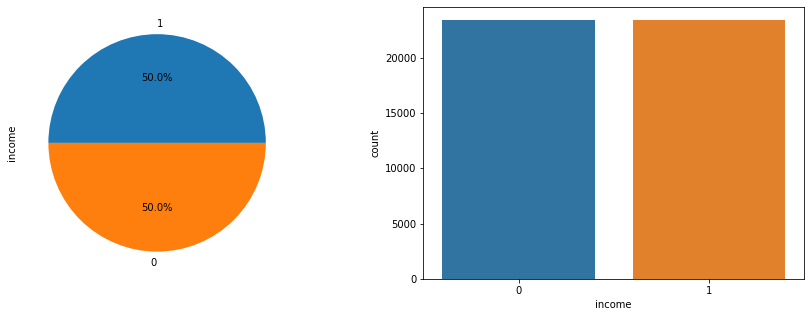

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
y.value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(y)
y.value_counts()

Data is balanced now, both the category of income have 50% data each.

##### Scaling the data

In [66]:
#Scaling the data using min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [67]:
xd=scaler.fit_transform(x)
x=pd.DataFrame(xd,columns=x.columns)

# Modelling Phase

In [ ]:
#We import Classification Models
from sklearn.naive_bayes import  GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [ ]:
#Function to find the best random state
def randomstate(x,y):
    maxx=0
    model=LogisticRegression()
    for i in range(1,201):
        xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=i)
        model.fit(xtrain,ytrain)
        p=model.predict(xtest)
        accu=accuracy_score(p,ytest)
        if accu>maxx:
            maxx=accu
            j=i
    return j

In [ ]:
#To evakuate performances of all the models
def performance(p,ytest,m,xtest,s):
    print('------------------------------------',m,'------------------------------------')
    print('Accuracy',np.round(accuracy_score(p,ytest),4))
    print('----------------------------------------------------------')
    print('Mean of Cross Validation Score',np.round(s.mean(),4))
    print('----------------------------------------------------------')
    print('AUC_ROC Score',np.round(roc_auc_score(ytest,m.predict_proba(xtest)[:,1]),4))
    print('----------------------------------------------------------')
    print('Confusion Matrix')
    print(confusion_matrix(p,ytest))
    print('----------------------------------------------------------')
    print('Classification Report')
    print(classification_report(p,ytest))

In [ ]:
#Creating a list of models which will be created one by one
models=[GaussianNB(),KNeighborsClassifier(),LogisticRegression(),DecisionTreeClassifier(),
        RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),XGBClassifier(verbosity=0)]

In [ ]:
#Creates and trains model from the models list
def createmodel(x,y):
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=randomstate(x,y))
    for i in models:
        model=i
        model.fit(xtrain,ytrain)
        p=model.predict(xtest)
        score=cross_val_score(model,x,y,cv=10)
        performance(p,ytest,model,xtest,score) 

In [ ]:
createmodel(x,y)

Random Forest, Gradient Boost, Xtreme Gradient Boost give us the best performance, so we further try hyperparameter tuning on them

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=randomstate(x,y))

##### Random Forest

In [ ]:
params={'n_estimators':[100,300,500],
            'criterion':['gini','entropty'],
            'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
           'max_features':['int','float','auto','log2']}

In [ ]:
g=GridSearchCV(RandomForestClassifier(),params,cv=10)

In [ ]:
g.fit(xtrain,ytrain)

In [ ]:
print(g.best_params_)
print(g.best_estimator_)
print(g.best_score_)

In [ ]:
m=RandomForestClassifier(max_features='log2', n_estimators=500)
m.fit(xtrain,ytrain)
p=m.predict(xtest)
score=cross_val_score(m,x,y,cv=10)
performance(p,ytest,m,xtest,score)

##### Gradient Boost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params={'n_estimators':[100,300,500],
      'learning_rate':[0.001,0.01,0.10,],
      'subsample':[0.5,1],
      'max_depth':[1,2,3,4,5,6,7,8,9,10,None]}

In [ ]:
g=RandomizedSearchCV(GradientBoostingClassifier(),params,cv=10)

In [ ]:
g.fit(xtrain,ytrain)

In [ ]:
print(g.best_params_)
print(g.best_estimator_)
print(g.best_score_)

In [ ]:
m=GradientBoostingClassifier(max_depth=8, subsample=0.5)
m.fit(xtrain,ytrain)
p=m.predict(xtest)
score=cross_val_score(m,x,y,cv=10)
performance(p,ytest,m,xtest,score)

##### Xtreme Gradient Boost

In [ ]:
params={
 "learning_rate"    : [0.01,0.05, 0.10, 0.15, ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [ ]:
g=RandomizedSearchCV(XGBClassifier(),params,cv=10)

In [ ]:
g.fit(xtrain,ytrain)

In [ ]:
print(g.best_params_)
print(g.best_estimator_)
print(g.best_score_)

In [ ]:
m=XGBClassifier(colsample_bytree=0.3, gamma= 0.1, learning_rate= 0.15, max_depth= 10, min_child_weight= 5)
m.fit(xtrain,ytrain)
p=m.predict(xtest)
score=cross_val_score(m,x,y,cv=10)
performance(p,ytest,m,xtest,score)

We choose random forest as our final model because it gives the highest cross validation score as well as difference between its accuracy score and cross validation score is minimum.

# Finalizing the model

In [ ]:
model=RandomForestClassifier(max_features='log2', n_estimators=500)
model.fit(xtrain,ytrain)
p=model.predict(xtest)
score=cross_val_score(model,x,y,cv=10)

# Evaluation Metrics

In [ ]:
performance(p,ytest,model,xtest,score)

In [ ]:
fpred=pd.Series(model.predict_proba(xtest)[:,1])
fpr,tpr,threshold=roc_curve(ytest,fpred)

In [ ]:
plt.plot(fpr,tpr,color='k',label='ROC')
plt.plot([0,1],[0,1],color='b',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend()

# Saving the model

In [ ]:
import joblib
joblib.dump(model,'census_income.obj')

## Fairness

In [68]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [69]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [70]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [71]:
train_data = pd.DataFrame(x)
train_data['income'] = pd.DataFrame(y)

In [72]:
#print(X)


#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = StandardDataset(train_data,
                                  label_name='income',
                                  protected_attribute_names=['sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])

#metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
#                                             unprivileged_groups=unprivileged_groups,
#                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


In [73]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.344600


In [74]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = XGBClassifier(n_estimators= 1, colsample_bytree=0.3, gamma= 0.1, learning_rate= 0.15, max_depth= 10, min_child_weight= 5)

mdl = model.fit(X_train, y_train)
with open('../../Results/XGBoost/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/XGBoost/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/XGBoost/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [75]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = XGBClassifier(n_estimators= i,colsample_bytree=0.3, gamma= 0.1, learning_rate= 0.15, max_depth= 10, min_child_weight= 5)
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [76]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
#print(final_result)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/XGBoost/' + nb_fname + '.csv')
final_result

classifier        T0        T1        T2  \
accuracy                         0.905372  0.733903  0.862682  0.863821   
f1                               0.906285  0.726088  0.868007  0.871973   
statistical_parity_difference   -0.356363 -0.177715 -0.384933 -0.422361   
equal_opportunity_difference    -0.057508 -0.032233 -0.080933 -0.109229   
average_abs_odds_difference      0.087213  0.028851  0.136779  0.175478   
disparate_impact                -0.942129 -0.435929 -0.951108 -1.029478   
theil_index                      0.065273  0.202809  0.082449  0.072154   

                                     T3        T4        T5        T6  \
accuracy                       0.863892  0.872928  0.871149  0.873070   
f1                             0.872764  0.879259  0.876408  0.879378   
statistical_parity_difference -0.424363 -0.431404 -0.451574 -0.429965   
equal_opportunity_difference  -0.100248 -0.137469 -0.209184 -0.135978   
average_abs_odds_difference    0.174667  0.185682  0.222183  0.184097   
disparate_impact              -1.020297 -1.097448 -1.213307 -1.092624   
theil_index                    0.069627  0.070705  0.075873  0.070668   

                                     T7        T8  ...       T90       T91  \
accuracy                       0.875133  0.877552  ...  0.905727  0.905514   
f1                             0.880360  0.882790  ...  0.906749  0.906492   
statistical_parity_difference -0.426017 -0.413126  ... -0.358422 -0.357731   
equal_opportunity_difference  -0.149210 -0.112763  ... -0.058072 -0.055897   
average_abs_odds_difference    0.183491  0.161978  ...  0.088801  0.087784   
disparate_impact              -1.104934 -1.051965  ... -0.946407 -0.945227   
theil_index                    0.072746  0.070728  ...  0.064576  0.064910   

                                    T92       T93       T94       T95  \
accuracy                       0.905514  0.905443  0.905514  0.905656   
f1                             0.906439  0.906428  0.906453  0.906593   
statistical_parity_difference -0.356942 -0.357449 -0.355997 -0.355997   
equal_opportunity_difference  -0.055212 -0.055897 -0.055383 -0.055554   
average_abs_odds_difference    0.086975  0.087597  0.086267  0.086236   
disparate_impact              -0.943876 -0.943987 -0.939992 -0.939992   
theil_index                    0.065122  0.064932  0.065069  0.064970   

                                    T96       T97       T98       T99  
accuracy                       0.905372  0.905301  0.905301  0.905372  
f1                             0.906325  0.906248  0.906248  0.906285  
statistical_parity_difference -0.355813 -0.356095 -0.356476 -0.356363  
equal_opportunity_difference  -0.056702 -0.057850 -0.057850 -0.057508  
average_abs_odds_difference    0.086553  0.087127  0.087430  0.087213  
disparate_impact              -0.938925 -0.940161 -0.941567 -0.942129  
theil_index                    0.065114  0.065190  0.065190  0.065273  

[7 rows x 101 columns]